# ER estimator V1

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

<img src="https://confusedcoders.com/wp-content/uploads/2019/06/untitled-3.jpg">

In [0]:
from fastai.tabular import *
from fastai.metrics import *

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
train_file = "20190912-to-20190918.csv"
# train_file = "train-20190919-to-20190921.csv"
# test_file = "test-20190919-to-20190921.csv"
path = '/content/drive/My Drive/'

In [9]:
train = pd.read_csv(path+train_file)
train = train.drop(columns=["sid","time","r_site_iab_cats","g_event_id"])
train[0:5], len(train)

(   r_dow  r_hod  a_er_cat  ...  s_gerry_type  s_caesar_id  response
 0      0     19         0  ...           0.0          NaN         0
 1      0     19         0  ...           NaN          NaN         0
 2      0     19         3  ...           NaN          NaN         0
 3      0     19         0  ...           NaN          NaN         0
 4      0     19         0  ...           NaN          NaN         0
 
 [5 rows x 22 columns], 2687317)

In [10]:
# extraction the test set from main dataset
valid_idx = range(int(len(train)*0.9), len(train))
valid_idx

range(2418585, 2687317)

In [11]:
test_df = train.iloc[valid_idx].copy()
# test_df = pd.read_csv(path+test_file)
# test_df = test_df.drop(columns=["sid","time","r_site_iab_cats","g_event_id"])
test_df.head(), len(test_df)

(         r_dow  r_hod  a_er_cat  ...  s_gerry_type  s_caesar_id  response
 2418585      0      7         0  ...           0.0          NaN         0
 2418586      0      7         0  ...           NaN          NaN         0
 2418587      0      7         0  ...           NaN          NaN         0
 2418588      0      7         0  ...           NaN          NaN         0
 2418589      0      7         0  ...           NaN          NaN         0
 
 [5 rows x 22 columns], 268732)

In [0]:
# We can define a bunch of Transforms that will be applied to our variables. Here we transform all categorical variables into categories. We also replace missing values for continuous variables by the median column value and normalize those.

In [0]:
procs = [FillMissing, Categorify, Normalize]

let's split our variables into categorical and continuous variables (we can ignore the label variable at this stage). fastai will assume all variables that aren't labels or categorical are continuous, unless we explicitly pass a list to the cont_names parameter when constructing our DataBunch.

In [14]:
label = 'response'
cat_names = [cat for cat in train.columns][:-1]
cat_names

['r_dow',
 'r_hod',
 'a_er_cat',
 'a_app_id',
 'a_campaign_type_id',
 'a_camp_id',
 'a_group_id',
 'r_source_id',
 'c_id',
 'r_site_id',
 'r_country_id',
 'r_region_code',
 'r_platform',
 'r_network_type',
 'r_traffic_type',
 'c_type',
 'c_cta',
 'c_text',
 'c_size',
 's_gerry_type',
 's_caesar_id']

ready to pass this information to TabularDataBunch.from_df to create the DataBunch that we'll use for training.

In [15]:
test = TabularList.from_df(test_df, cat_names=cat_names, cont_names=[], procs=procs)


data = (TabularList.from_df(train, path='.', cat_names=cat_names, procs=procs)
                        .split_by_idx(list(valid_idx))  # this is for splitting into train and test set.
                        .label_from_df(cols = label)
                        .add_test(test, label=0)
                        .databunch())
print(data.train_ds.cat_names)
print(data.train_ds.cont_names)
print(data.test_ds.cat_names)
print(data.test_ds.cont_names)

['r_dow', 'r_hod', 'a_er_cat', 'a_app_id', 'a_campaign_type_id', 'a_camp_id', 'a_group_id', 'r_source_id', 'c_id', 'r_site_id', 'r_country_id', 'r_region_code', 'r_platform', 'r_network_type', 'r_traffic_type', 'c_type', 'c_cta', 'c_text', 'c_size', 's_gerry_type', 's_caesar_id']
[]
['r_dow', 'r_hod', 'a_er_cat', 'a_app_id', 'a_campaign_type_id', 'a_camp_id', 'a_group_id', 'r_source_id', 'c_id', 'r_site_id', 'r_country_id', 'r_region_code', 'r_platform', 'r_network_type', 'r_traffic_type', 'c_type', 'c_cta', 'c_text', 'c_size', 's_gerry_type', 's_caesar_id']
[]


In [16]:
(cat_x,cont_x),y = next(iter(data.train_dl))
for o in (cat_x, cont_x, y): print(to_np(o[:5]))

[[  2  23   1  48 ...   0   9   0   0]
 [  7  17   1   9 ...  71   1   0   0]
 [  5  12   1  19 ...   0   7   0   0]
 [  6   9   1  53 ... 130   1   0   0]
 [  3   8   1  47 ...   9   9   0   0]]
[0 0 0 0 0]
[0 0 0 0 0]


Why I used Beta(1):
http://www.marcelonet.com/snippets/machine-learning/evaluation-metrix/f-beta-score

In [17]:
emb_szs = { cat:25 for cat in cat_names}
emb_szs

{'a_app_id': 25,
 'a_camp_id': 25,
 'a_campaign_type_id': 25,
 'a_er_cat': 25,
 'a_group_id': 25,
 'c_cta': 25,
 'c_id': 25,
 'c_size': 25,
 'c_text': 25,
 'c_type': 25,
 'r_country_id': 25,
 'r_dow': 25,
 'r_hod': 25,
 'r_network_type': 25,
 'r_platform': 25,
 'r_region_code': 25,
 'r_site_id': 25,
 'r_source_id': 25,
 'r_traffic_type': 25,
 's_caesar_id': 25,
 's_gerry_type': 25}

In [0]:
f1_score =FBeta(average='macro',beta = 1) #partial(fbeta, thresh=0.2, beta = 1)
prec=Precision(average='macro')
recall=Recall(average='macro')
# acc_02 = partial(accuracy_thresh, thresh=0.2)
learn = tabular_learner(data, layers=[1000, 200, 15], emb_szs=emb_szs, metrics=[error_rate,prec,recall,accuracy,f1_score],emb_drop=0.1, callback_fns=ShowGraph)

In [0]:
#partial(fbeta, thresh=0.2, beta = 1)
#f_score = partial(fbeta, thresh=0.2)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


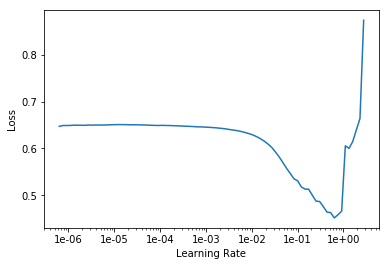

In [19]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,precision,recall,accuracy,f_beta,time
0,0.074772,440.350677,0.020001,0.498615,0.499894,0.979999,0.496063,11:06


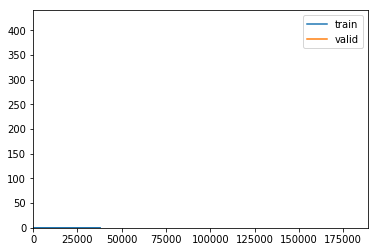

In [0]:
learn.fit_one_cycle(5, max_lr=slice(1e-01))

In [0]:
# export weights as pickle
learn.export()
!ls .

In [4]:
def plot_confusion_matrix(self, normalize:bool=False, title:str='Confusion matrix', cmap:Any="Blues", slice_size:int=1, norm_dec:int=2, **kwargs)->None:
  "Plot the confusion matrix, with `title` and using `cmap`."
  # This function is mainly copied from the sklearn docs
  cm = self.confusion_matrix(slice_size=slice_size)
  plt.figure(**kwargs)
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  tick_marks = np.arange(self.data.c)
  plt.xticks(tick_marks, self.data.y.classes, rotation=90)
  plt.yticks(tick_marks, self.data.y.classes, rotation=0)

  if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      coeff = f'{cm[i, j]:.{norm_dec}f}' if normalize else f'{cm[i, j]}'
      plt.text(j, i, coeff, horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
   
   
interp = ClassificationInterpretation.from_learner(learn)
print(interp.confusion_matrix())
plot_confusion_matrix(interp)

NameError: ignored

In [18]:
thresh = 0.08
print(learn.predict(test_df.loc[2418640], thresh=thresh) )
print(learn.predict(test_df.loc[2418641], thresh=thresh) )
#test_df.loc[2418585], test_df.iloc[0]

(Category 0, tensor(0), tensor([0.8111, 0.1889]))
(Category 0, tensor(0), tensor([0.9613, 0.0387]))


In [0]:
# test_df

In [0]:
test_df[test_df['response'] == 1]

In [20]:
test_pos = test_df[test_df['response'] == 1]
pos_cant = len(test_pos)
print("positives:",pos_cant)

res = []
for i in range(0,1000):
    pred = learn.predict(test_pos.iloc[i])
    cat = pred[1].numpy()
    val = pred[2].numpy()[1]
    res.append((cat,val))

arr = pd.DataFrame(res)
pos = arr[arr[1] >= thresh]
print(len(pos),len(arr))
print("Sensitivity: ",len(pos)/len(arr))

positives: 5009
313 1000
Sensitivity:  0.313


In [21]:
negative = test_df[test_df['response'] == 0]
neg_cant = len(negative)
print("negative:",neg_cant)

res_neg = []
for i in range(0,int(1000)):
    pred = learn.predict(negative.iloc[i])
    cat = pred[1].numpy()
    val = pred[2].numpy()[1]
    res_neg.append((cat,val))

arr_neg = pd.DataFrame(res_neg)

neg = arr_neg[arr_neg[1] < thresh]
print(len(neg),len(arr_neg))
print("Specificity: ",len(neg)/len(arr_neg))

negative: 263723
967 1000
Specificity:  0.967


In [5]:
specificity = len(neg)/len(arr_neg)
sensitivity = len(pos)/len(arr)
specificity,sensitivity
# train
f1 = 2*sensitivity*specificity/ (specificity+sensitivity)
print("F1 Score: ",f1)

NameError: ignored